# NetLogo Results Analysis for the Compound Events Model

The hunter-gatherers have 3 different strategies of surviving. The first one is to have great skill at hunting and gathering. By being able to harvest more units per band member per day, the band requires less time to harvest their needs and have more time to explore, move and prepare for future seasons. The second strategy is to cooperate with other bands and gain as much knowledge as possible. This would mean being able to move to locally optimal patches, but also improve the skill of hunting and gathering by learning from other bands. The third option is based around mobility and will create a simulation where bands travel a lot, without losing much time.

## 1. Experiment Setup


- max_effectiveness (policy lever) | [2 - 6 - 10]

If bands were to have invested in their efficiency to hunt and gather, this could create a higher survivability. This parameter will show the relative importance of skill.


- cooperation_radius (policy_lever) | [1 - 3 - 5]

This parameter focuses on the cooperation and sharing of knowledge between bands. It will show the relative importance of working together and acquiring knowledge.


- maximum_days_moving (policy lever) | [10 - 30 - 50]

This parameter will show the relative importance of the ability to move around easily.

- start_event | [60 - 120 - 240]

Altering the starting time of the volcano eruption will show how important it is for bands to be fully prepared for such a shock. Also, the situation where no volcano erupted at all will be analysed.

- GISP2_trend | [On - Off]
Turning the existence of climate change on or off will show the impact of the stress of low temperature on the survivability of the bands. Together with the volcano eruption, this will create 4 possible situations: stable model, only climate change, only eruption, compound event.


Out of these parameters, a full facotorial experiment setup will be run. There will be 10 replications for each set of parameter combination. 

## 2. Data Preparation

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

In [2]:
# Adjust this to where you have saved the experiment results
# Skip the first 6 rows to get to the data
df_results = pd.read_csv("Draft Experiments/base-experiment-trendtrue.csv", skiprows = 6) 
df_no_climate = pd.read_csv("Draft Experiments/base-experiment-trendfalse.csv", skiprows = 6)
df_no_climate["[run number]"] = df_no_climate["[run number]"] + 1000 # Quick hack to differentiate between the different run numbers (everything above 1000 is no climate trend)
df_results = df_results.append(df_no_climate)

In [3]:
# Make the dataframe smaller by only selecting columns that are needed
# for parameter columns: only keep max_effectiveness, cooperation_radius, 
# maximum_days_moving, start_event - the rest is fixed to certain parameters (see report)
# 'GISP2_trend' not necessary because the results file is already split
columns = list(df_results.columns) # See which parameters and reporters are in the dataframe
parameter_columns = ['[run number]', 'max_effectiveness', 'cooperation_radius', 'maximum_days_moving',
                    'start_event', 'GISP2_trend']
kpi_columns = columns[60:]
columns_needed = parameter_columns + kpi_columns

df_results_small = df_results[columns_needed] # Create a new DF with the smaller subset of columns
df_results_small.rename(columns={'[run number]':'run_number','[step]':'tick'}, inplace=True) # Change the column names to make more sense

C:\Users\newbi\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
# Remove the data at tick 0 because most of the reporters do not have a value at the start
df_results_small = df_results_small[df_results_small['tick'] != 0]

# Add the deaths of the impact from the volcano eruption together
df_results_small['death_by_event'] = df_results_small['death_by_volcano'] + df_results_small['death_by_ash']

# Change True/False to 1/0
df_results_small['GISP2_trend'] = df_results_small['GISP2_trend'].astype(int)

# Calculate the mean population of a run
run_numbers = np.sort(df_results_small['run_number'].unique())
for i in run_numbers:
    df_run = df_results_small[df_results_small['run_number'] == i]
    mean_pop_run = df_run["total_population"].mean()
    df_results_small.loc[df_results_small['run_number'] == i, 'mean_population'] = mean_pop_run
    
df_results_small["communities_by_bands"] = df_results_small['number_of_communities'] / df_results_small['total_number_of_bands']

In [5]:
df_results_small.columns # See which parameters and reporters are in the dataframe

Index(['run_number', 'max_effectiveness', 'cooperation_radius',
       'maximum_days_moving', 'start_event', 'GISP2_trend', 'tick',
       'average_temperature_of_patches', 'average_precipitation_of_patches',
       'impact_by_ash', 'death_by_volcano', 'death_by_ash',
       'event_cultural_capital_loss', 'lost_resources',
       'average_food_available', 'average_resources_available',
       'number_of_communities', 'average_community_size', 'number_of_links',
       'average_knowledge_locations', 'average_cultural_capital',
       'average_technology_level', 'average_time_spent_moving',
       'mean_group_size', 'total_number_of_bands', 'total_population',
       'death_by_event', 'mean_population', 'communities_by_bands'],
      dtype='object')

In [6]:
# Set up 4 dataframes that show the different scenarios
# Start Event volcano eruption at 240 is when the volcano never erupts, because the model ends before that. 
# Start Event volcano 120 is the scenario we take where a volcano erupted in the middle of the model.
df_bc = df_results_small[(df_results_small['start_event'] == 240) & (df_results_small['GISP2_trend'] == 0)]
df_bc["scenario"] = 'basecase'
df_ve = df_results_small[(df_results_small['start_event'] == 120) & (df_results_small['GISP2_trend'] == 0)]
df_ve["scenario"] = 'volcano_eruption'
df_cc = df_results_small[(df_results_small['start_event'] == 240) & (df_results_small['GISP2_trend'] == 1)]
df_cc['scenario'] = 'climate_change'
df_ve_cc = df_results_small[(df_results_small['start_event'] == 120) & (df_results_small['GISP2_trend'] == 1)]
df_ve_cc['scenario'] = 'volcano_eruption_climate_change'

# Quick way to only take the scenarios we are interested in and label them.
df_scenarios = pd.concat([df_bc, df_ve, df_cc, df_ve_cc])
df_scenarios_final = df_scenarios[df_scenarios['tick'].isin([240])]

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

Thist table shows the four scenarios with the dataframe names.

| DataFrame Name | Volcano Eruption | Climate Change |
|----------------|------------------|----------------|
| df_bc          | 0                | 0              |
| df_ve          | 1                | 0              |
| df_cc          | 0                | 1              |
| df_ve_cc       | 1                | 1              |

## 3. Data Analysis

### 3.1 Population

#### 3.1.1 Population over Time

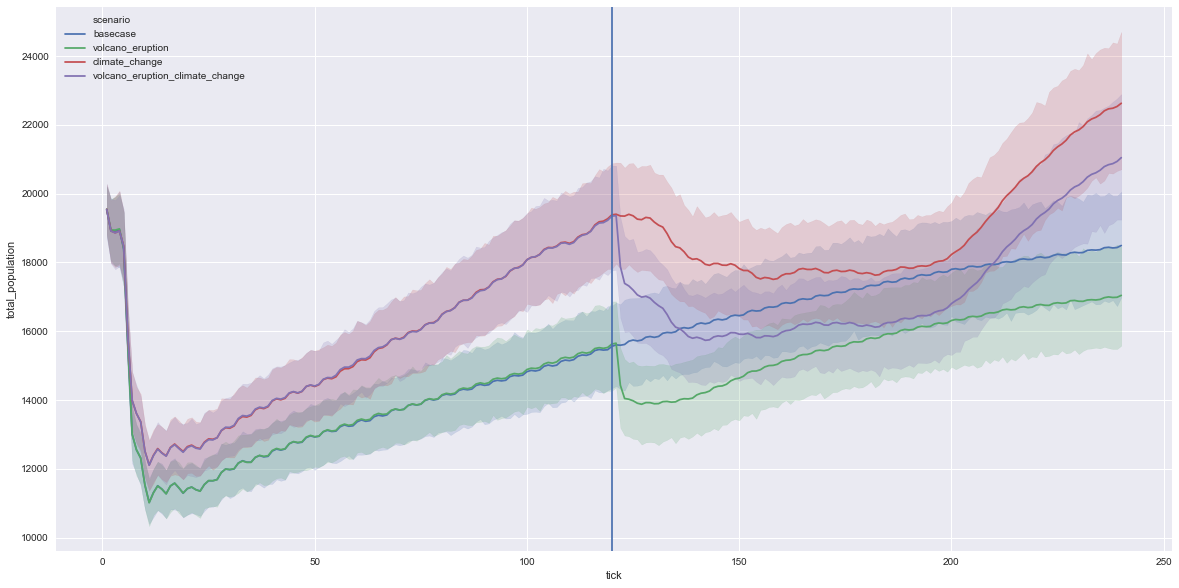

In [8]:
# Create a figure of the total population over time, with the mean and a confidence interval of 95%.
# The vertical line is set on tick 120 - because that is when the volcano erupts
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="total_population", data=df_scenarios, hue="scenario", ci = 95)
ax.axvline(x=120)
ax.legend(loc = 'upper left')
plt.show()
fig.savefig('images/population.png')

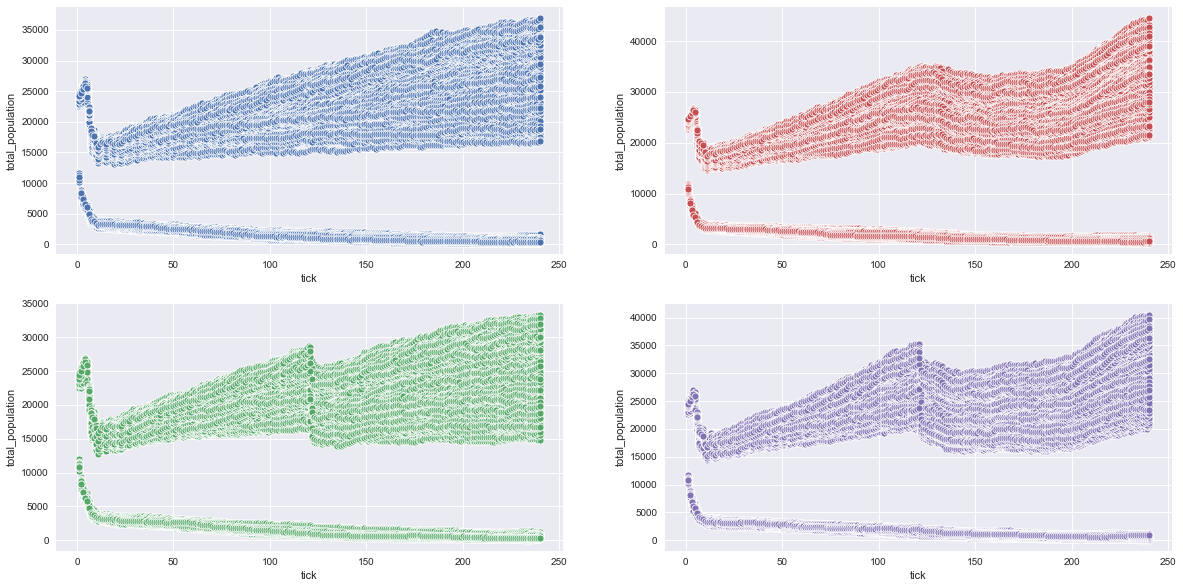

In [10]:
# Create a figure where each run is seperated to visualize the behavior of the runs in the four different scenarios. 
# It uses the same coloring scheme as the previous legend

fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))
current_palette = sns.color_palette()

sns.scatterplot(x="tick", y="total_population", data=df_bc, c=current_palette[0], ax = ax1)
sns.scatterplot(x="tick", y="total_population", data=df_ve, c=current_palette[1], ax = ax2)
sns.scatterplot(x="tick", y="total_population", data=df_cc, c=current_palette[2], ax = ax3)
sns.scatterplot(x="tick", y="total_population", data=df_ve_cc, c=current_palette[3], ax = ax4)
plt.show()
fig.savefig('images/population_split_scenarios.png')

#### 3.1.2 Average Food Availability over Time

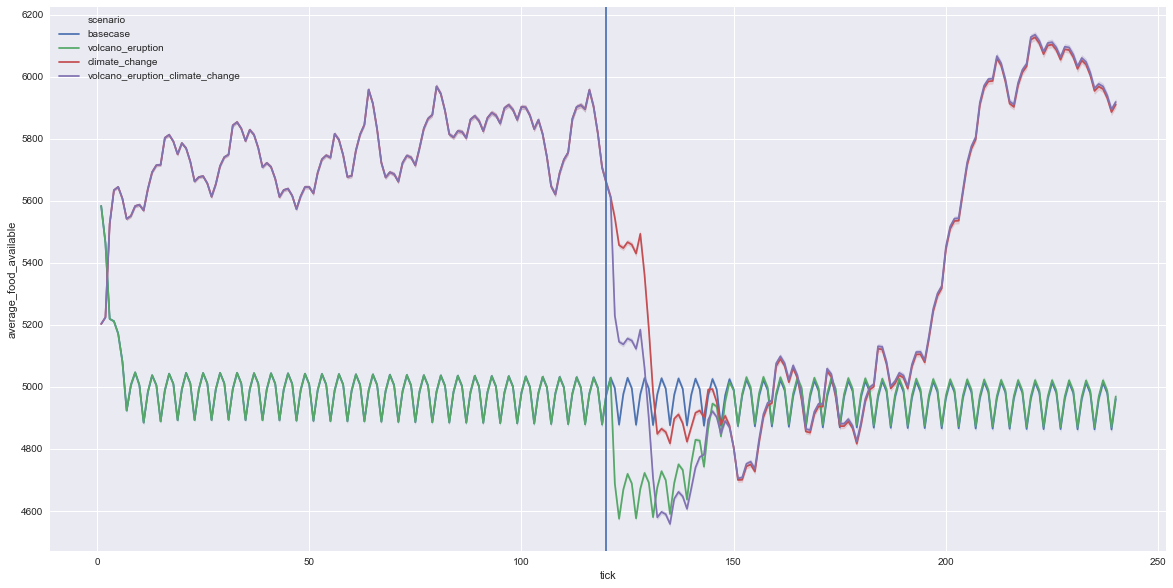

In [11]:
# Plot similar to population, however, done over average food available instead.
# It is one of the factors explaining the behavior of population!

fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="average_food_available", data=df_scenarios, hue="scenario", ci = 95)
ax.axvline(x=120)
plt.show()
fig.savefig('images/average_food_available.png')

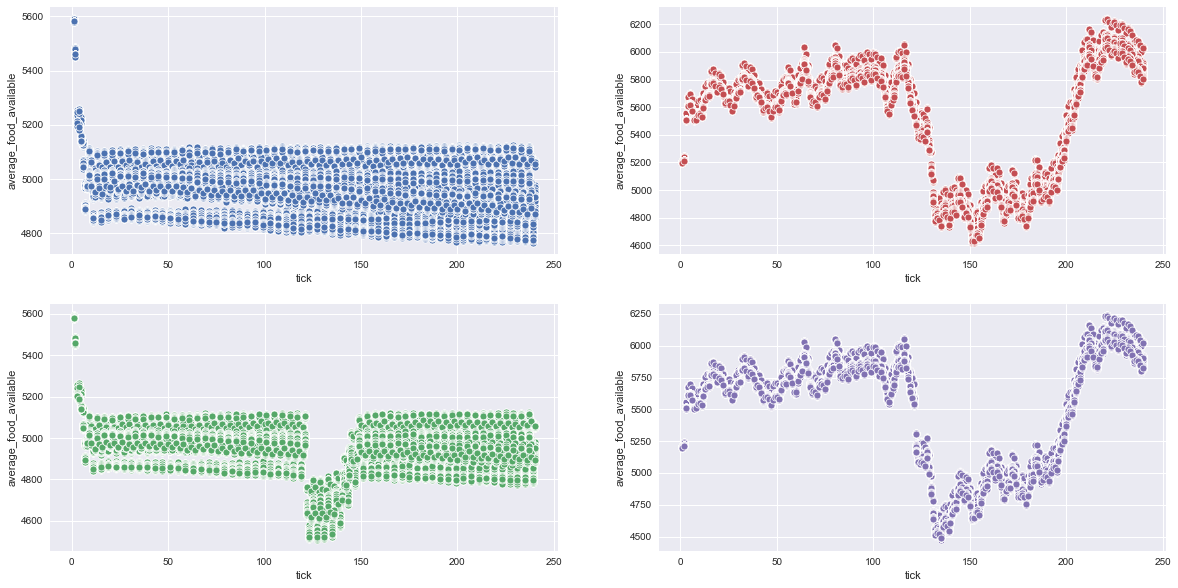

In [12]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

sns.scatterplot(x="tick", y="average_food_available", data=df_bc, c=current_palette[0], ax = ax1)
sns.scatterplot(x="tick", y="average_food_available", data=df_ve, c=current_palette[1], ax = ax2)
sns.scatterplot(x="tick", y="average_food_available", data=df_cc, c=current_palette[2], ax = ax3)
sns.scatterplot(x="tick", y="average_food_available", data=df_ve_cc, c=current_palette[3], ax = ax4)
plt.show()
fig.savefig('images/average_food_available_split_scenarios.png')

#### 3.1.3 Boxplots Parameters on Population

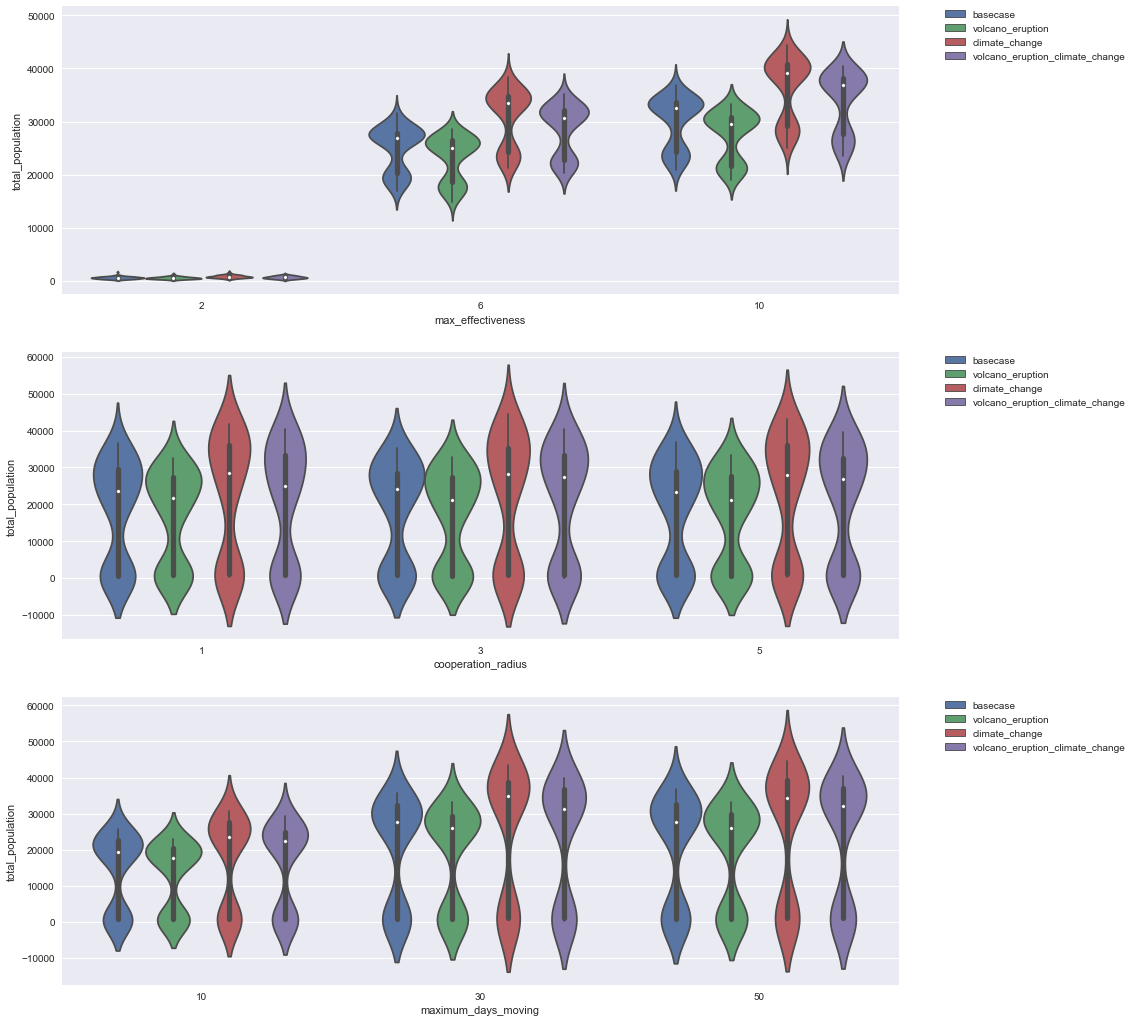

In [13]:
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

sns.violinplot(x="max_effectiveness", y="total_population", hue="scenario", data=df_scenarios_final, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.violinplot(x="cooperation_radius", y="total_population", hue="scenario", data=df_scenarios_final, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.violinplot(x="maximum_days_moving", y="total_population", hue="scenario", data=df_scenarios_final, ax=ax3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
fig.savefig('images/boxplots_population.png')

#### 3.1.4 T-Tests on the Population in Four Different Scenarios

In [14]:
from scipy.stats import ttest_ind, stats

df_bc_grouped = df_bc.groupby(by = "tick")["total_population"]
df_ve_grouped = df_ve.groupby(by = "tick")["total_population"]
df_cc_grouped = df_cc.groupby(by = "tick")["total_population"]
df_ve_cc_grouped = df_ve_cc.groupby(by = "tick")["total_population"]

list_of_populations_per_tick_bc = []
list_of_populations_per_tick_cc = []

for group in df_bc_grouped:
    list_of_populations_per_tick_bc.append(list(group[1]))
    
for group in df_cc_grouped:
    list_of_populations_per_tick_cc.append(list(group[1]))
    
t_test_outcomes_bc_ve = []
i = 0
for group in df_ve_grouped:
    t, p = stats.ttest_ind(list(group[1]), list_of_populations_per_tick_bc[i])
    t_test_outcomes_bc_ve.append(p)
    i = i + 1

t_test_outcomes_cc_vecc = []    
i = 0
for group in df_ve_cc_grouped:
    t, p = stats.ttest_ind(list(group[1]), list_of_populations_per_tick_cc[i])
    t_test_outcomes_cc_vecc.append(p)
    i = i + 1

    
t_test_outcomes_bc_cc = []    
i = 0
for group in df_bc_grouped:
    t, p = stats.ttest_ind(list(group[1]), list_of_populations_per_tick_cc[i])
    t_test_outcomes_bc_cc.append(p)
    i = i + 1
    
list_of_ticks = list(range(1, 241))

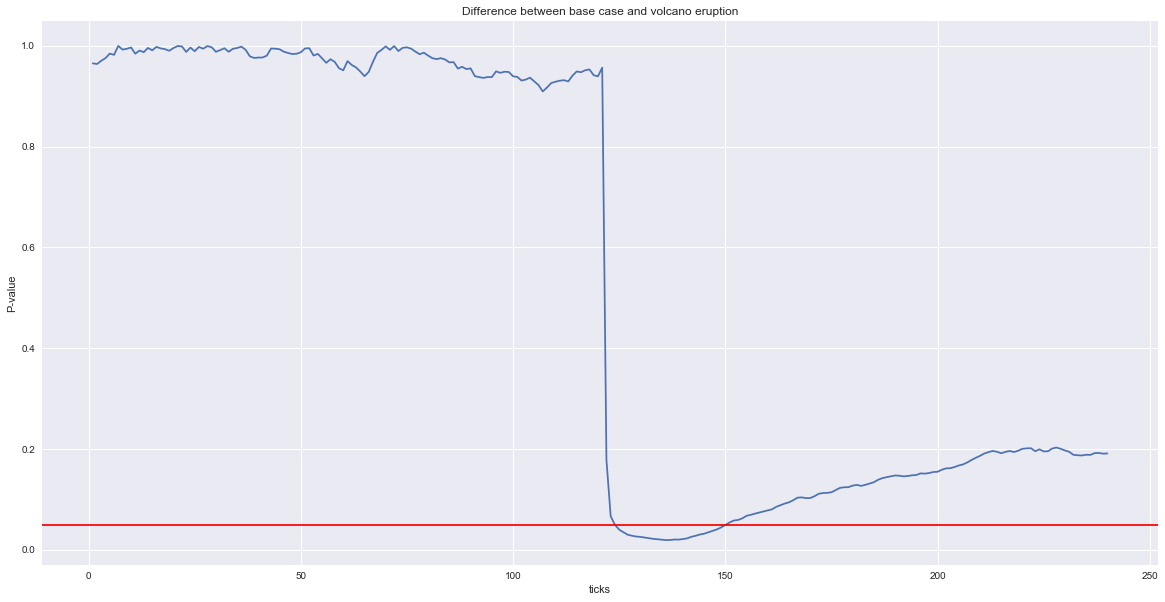

In [15]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x=list_of_ticks, y=t_test_outcomes_bc_ve)
plt.axhline(y=0.05, color = "red")
plt.xlabel("ticks")
plt.ylabel("P-value")
plt.title("Difference between base case and volcano eruption")
plt.show()

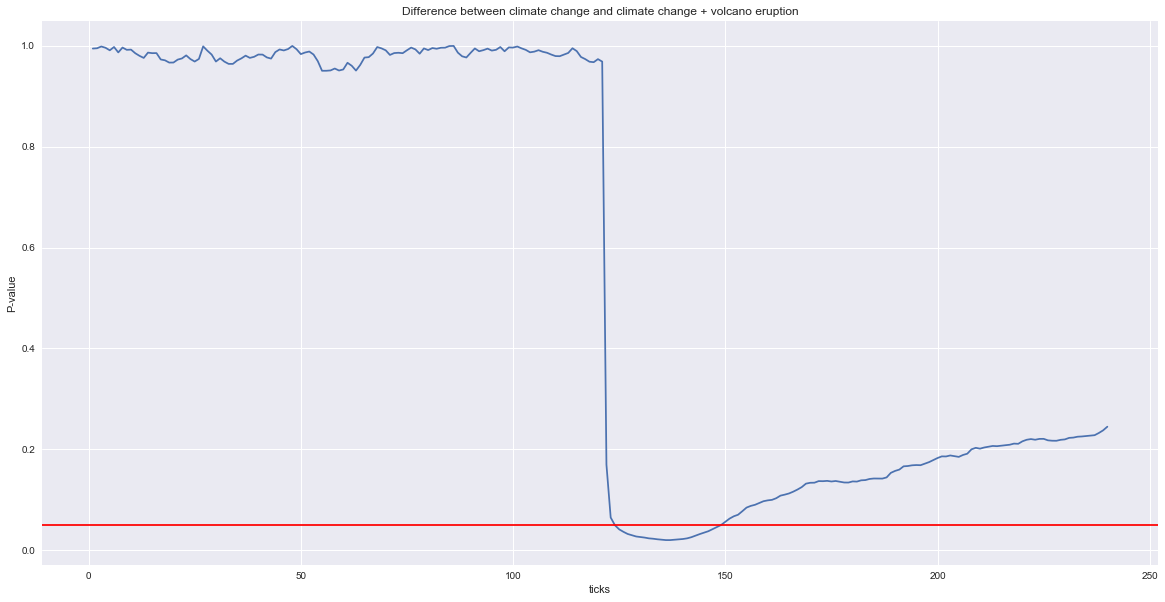

In [16]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x=list_of_ticks, y=t_test_outcomes_cc_vecc)
plt.axhline(y=0.05, color = "red")
plt.xlabel("ticks")
plt.ylabel("P-value")
plt.title("Difference between climate change and climate change + volcano eruption")
plt.show()

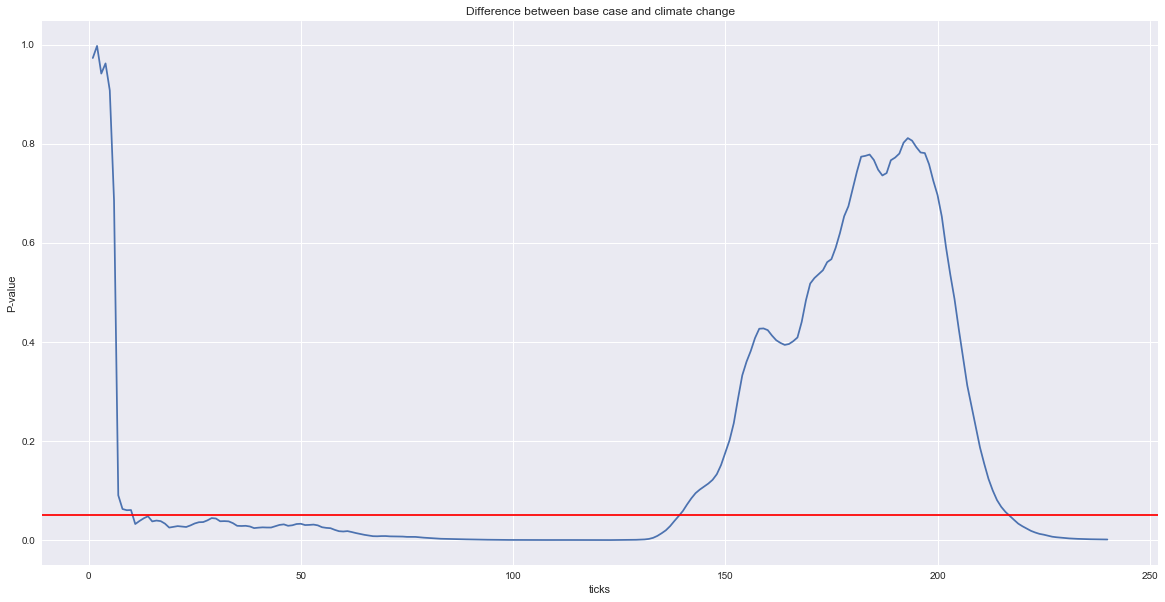

In [17]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x=list_of_ticks, y=t_test_outcomes_bc_cc)
plt.axhline(y=0.05, color = "red")
plt.xlabel("ticks")
plt.ylabel("P-value")
plt.title("Difference between base case and climate change")
plt.show()

#### 3.1.5 Anova on Population Scenarios [discarded] 

In [18]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [19]:
results = ols('total_population ~ C(scenario)', data=df_scenarios_final).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_population   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.192
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           2.15e-05
Time:                        14:49:17   Log-Likelihood:                -11871.
No. Observations:                1080   AIC:                         2.375e+04
Df Residuals:                    1076   BIC:                         2.377e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                       1.849e+04    876.146     21.108      0.000    1.68e+04    2.02e+04
C(scenario)[T.climate_change]                   4135.4481   1239.058      3.338      0.001    1704.204    6566.692
C(scenario)[T.volcano_eruption]                -1449.9185   1239.058     -1.170      0.242   -3881.162     981.325
C(scenario)[T.volcano_eruption_climate_change]  2554.2444   1239.058      2.061      0.040     123.001    4985.488
==============================================================================
Omnibus:                     9584.316   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.510
Skew:                          -0.422   Prob(JB):                     3.38e-28
Kurtosis:                       1.552   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(scenario),5.093429e+09,3.0,8.191661,0.000022
Residual,2.230126e+11,1076.0,NaN,NaN


### 3.2 Cultural Capital and Technology Level

In [22]:
# Create a new column with the difference of average cultural capital and average technology level
df_scenarios["diff_cult_tech"] = df_scenarios["average_cultural_capital"] - df_scenarios["average_technology_level"]

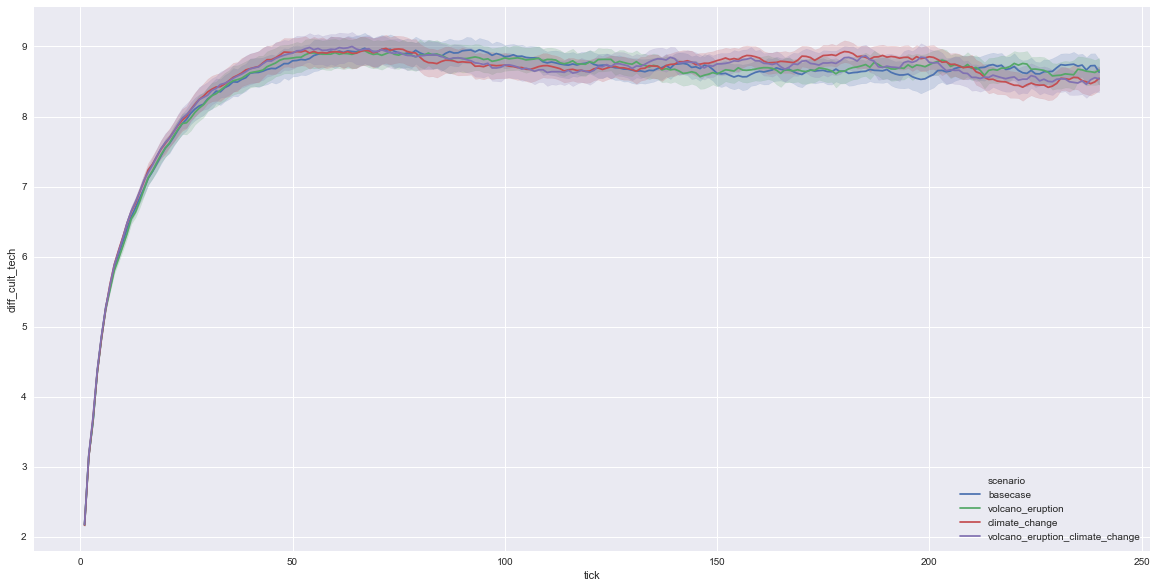

In [23]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="diff_cult_tech", data=df_scenarios, hue="scenario", ci=95)
plt.show()
fig.savefig('images/potential_cc')

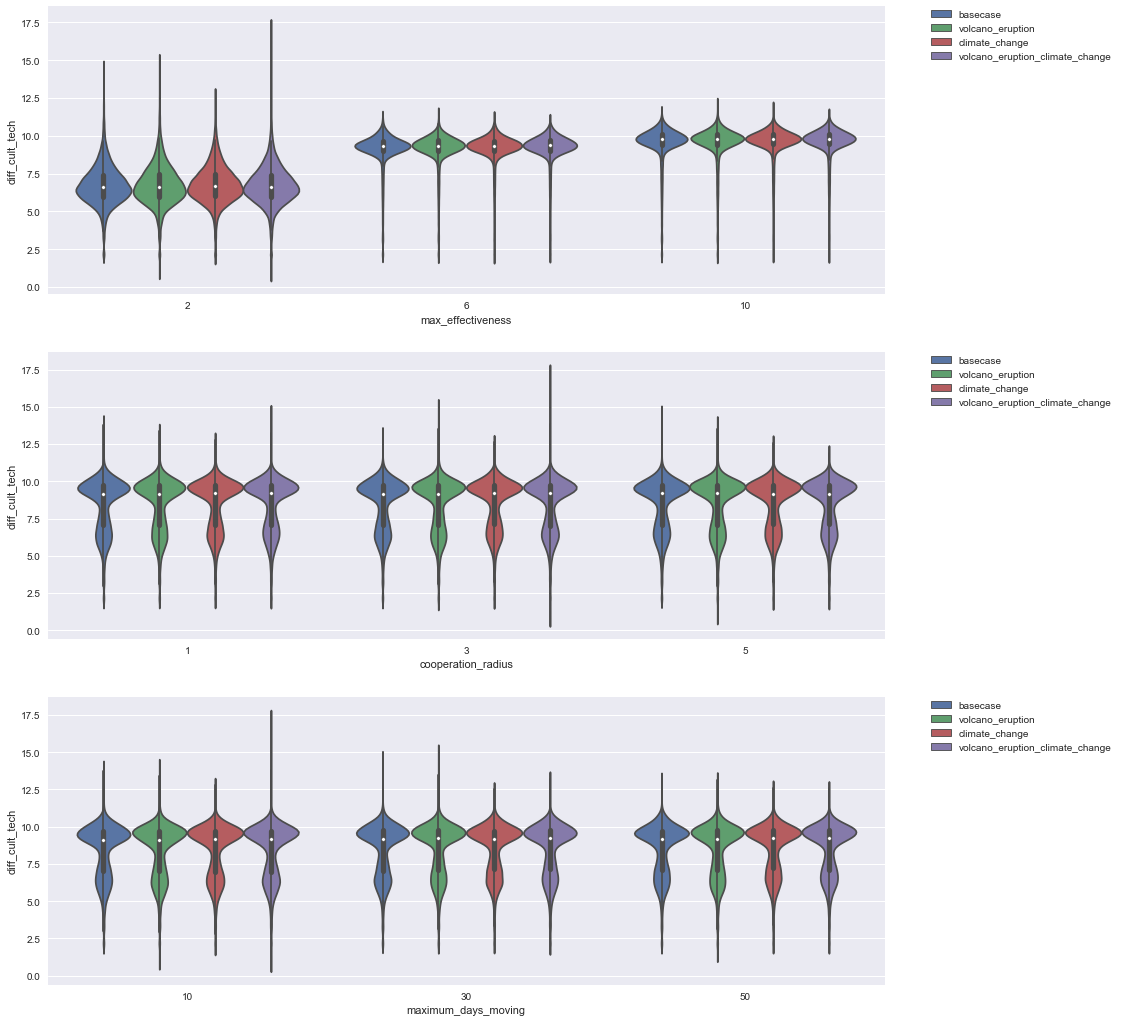

In [24]:
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

sns.violinplot(x="max_effectiveness", y="diff_cult_tech", hue="scenario", data=df_scenarios, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.violinplot(x="cooperation_radius", y="diff_cult_tech", hue="scenario", data=df_scenarios, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.violinplot(x="maximum_days_moving", y="diff_cult_tech", hue="scenario", data=df_scenarios, ax=ax3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
fig.savefig('images/boxplots_potential_cc')

### 3.3 Average Knowledge Locations

In [11]:
df_results_small_final = df_results_small[df_results_small['tick'].isin([240])]

#### 3.3.1 Average Known Locations over Time

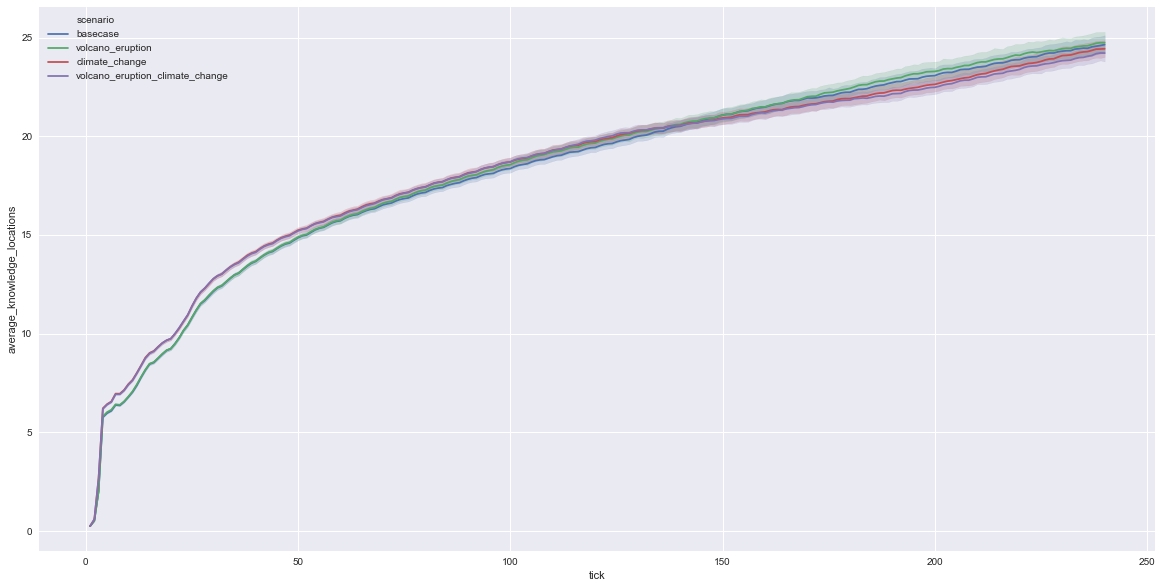

In [33]:
# Figure showing the average known locations over the four scenarios.
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="average_knowledge_locations", data=df_scenarios, hue="scenario", ci=95)
plt.show()
fig.savefig('images/average_knowledge_locations')

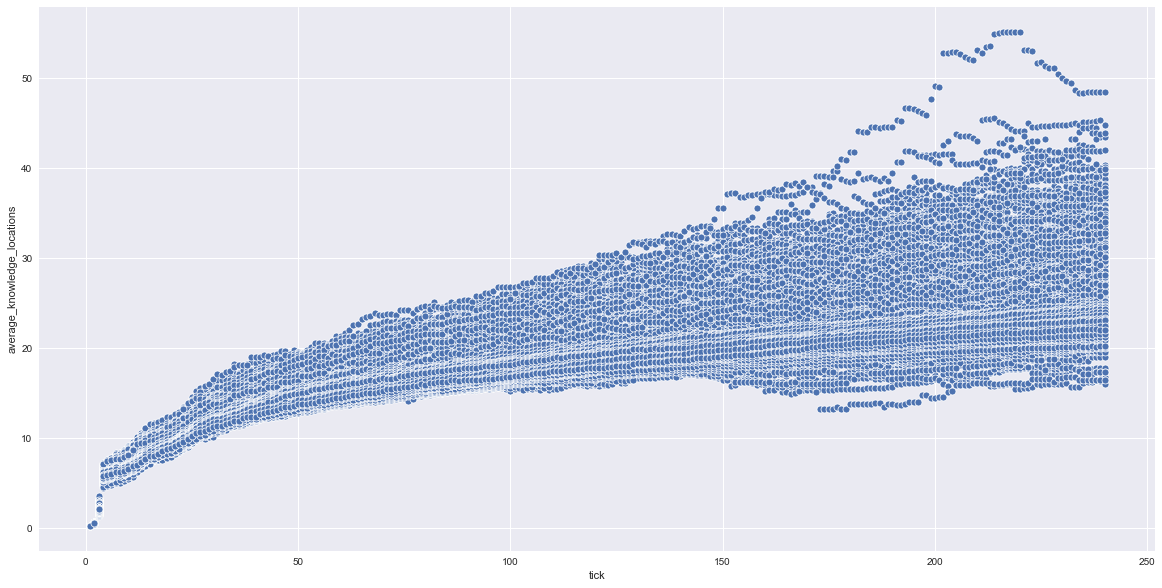

In [27]:
# Figure showing a scatterplot of the KPI over time
fig = plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="tick", y="average_knowledge_locations", data=df_results_small)
plt.show()

#### 3.3.2 Violinplots Average Knowledge

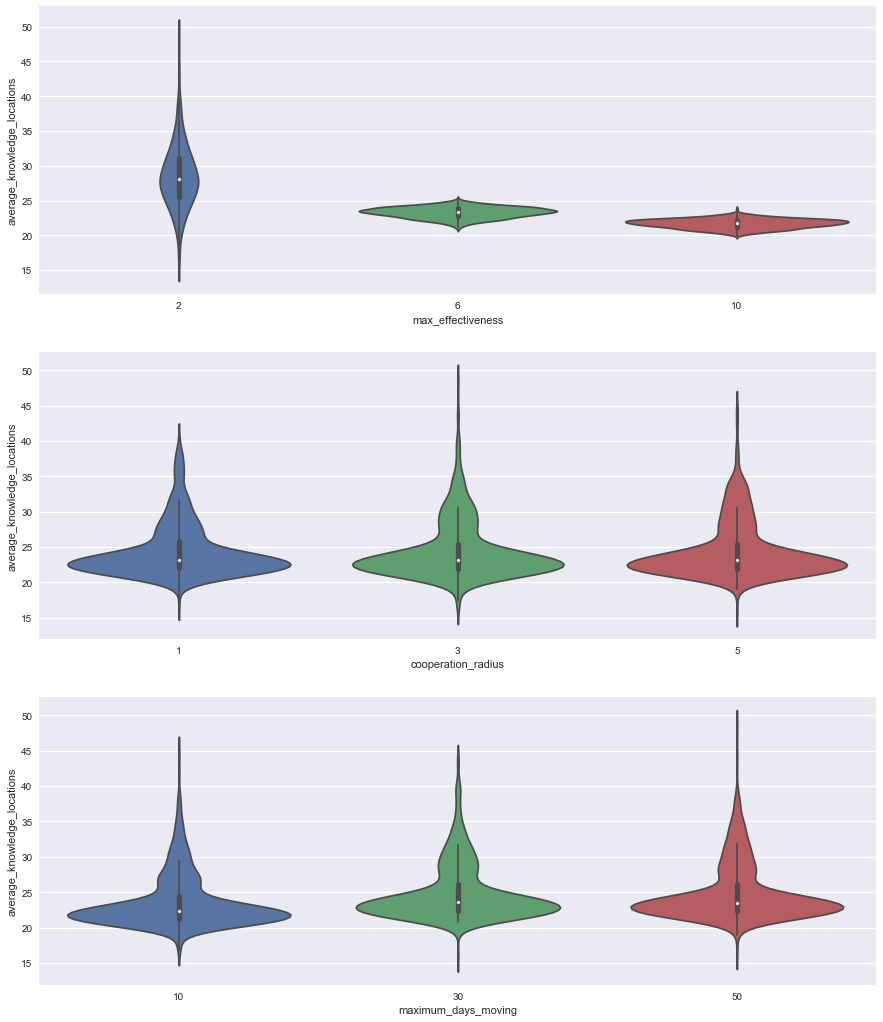

In [28]:
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

sns.violinplot(x="max_effectiveness", y="average_knowledge_locations", data=df_results_small_final, ax=ax1)
sns.violinplot(x="cooperation_radius", y="average_knowledge_locations", data=df_results_small_final, ax=ax2)
sns.violinplot(x="maximum_days_moving", y="average_knowledge_locations", data=df_results_small_final, ax=ax3)

plt.show()
fig.savefig('images/boxplots_average_knowledge_locations')

#### 3.3.3 Selective Runs showcasing Average Knowledge Locations

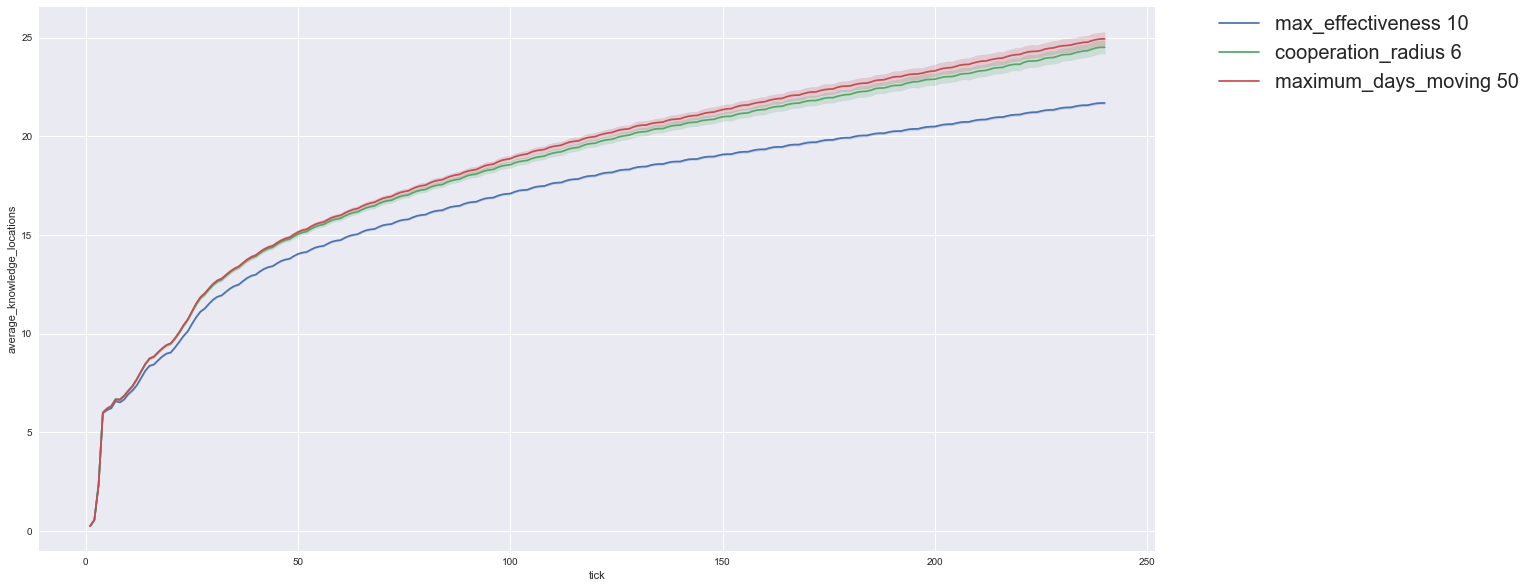

In [32]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="average_knowledge_locations", data=df_results_small[df_results_small['max_effectiveness'] == 10], label="max_effectiveness 10")
ax = sns.lineplot(x="tick", y="average_knowledge_locations", data=df_results_small[df_results_small['cooperation_radius'] == 5], label="cooperation_radius 6")
ax = sns.lineplot(x="tick", y="average_knowledge_locations", data=df_results_small[df_results_small['maximum_days_moving'] == 50], label="maximum_days_moving 50")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

plt.show()
fig.savefig("images/average_time_spent_moving_per_max_parameter")

### 3.4 Average Time Spent Moving

#### 3.4.1 Average Time Spent Moving all runs over time

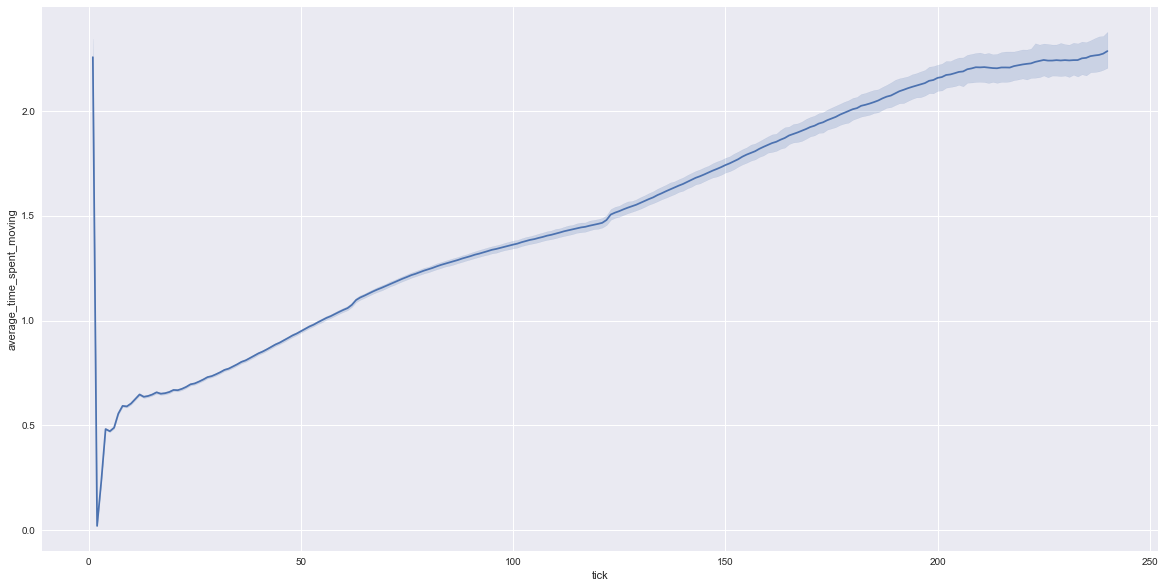

In [34]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="average_time_spent_moving", data=df_results_small, ci = 95)
plt.show()
# fig.savefig("images/average_time_spent_moving")

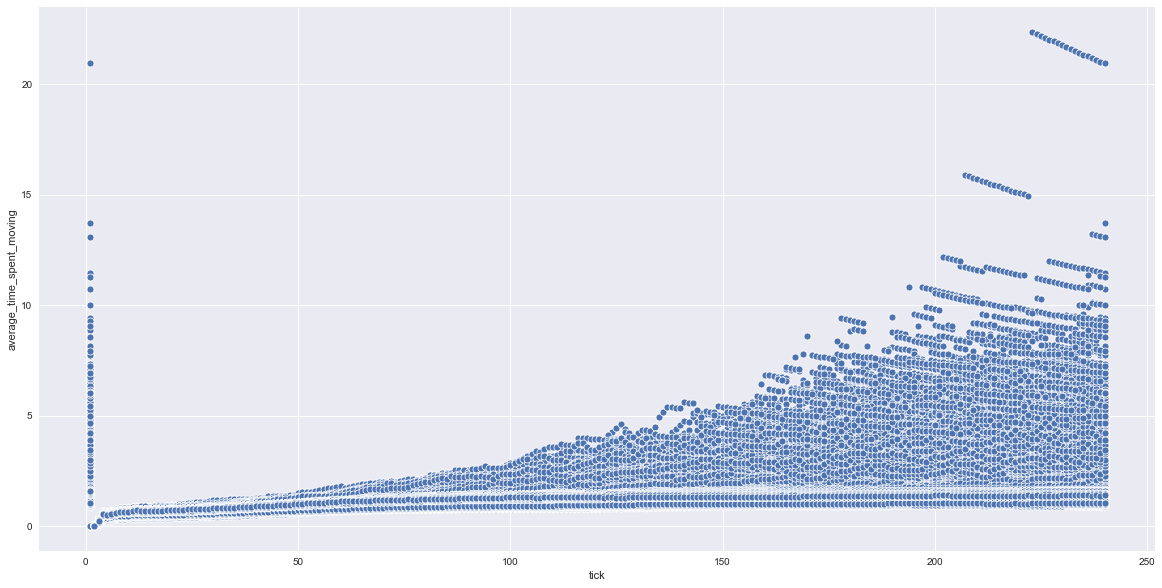

In [35]:
fig = plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="tick", y="average_time_spent_moving", data=df_results_small)
plt.show()

#### 3.4.2 Violinplots parameters on average time spent moving

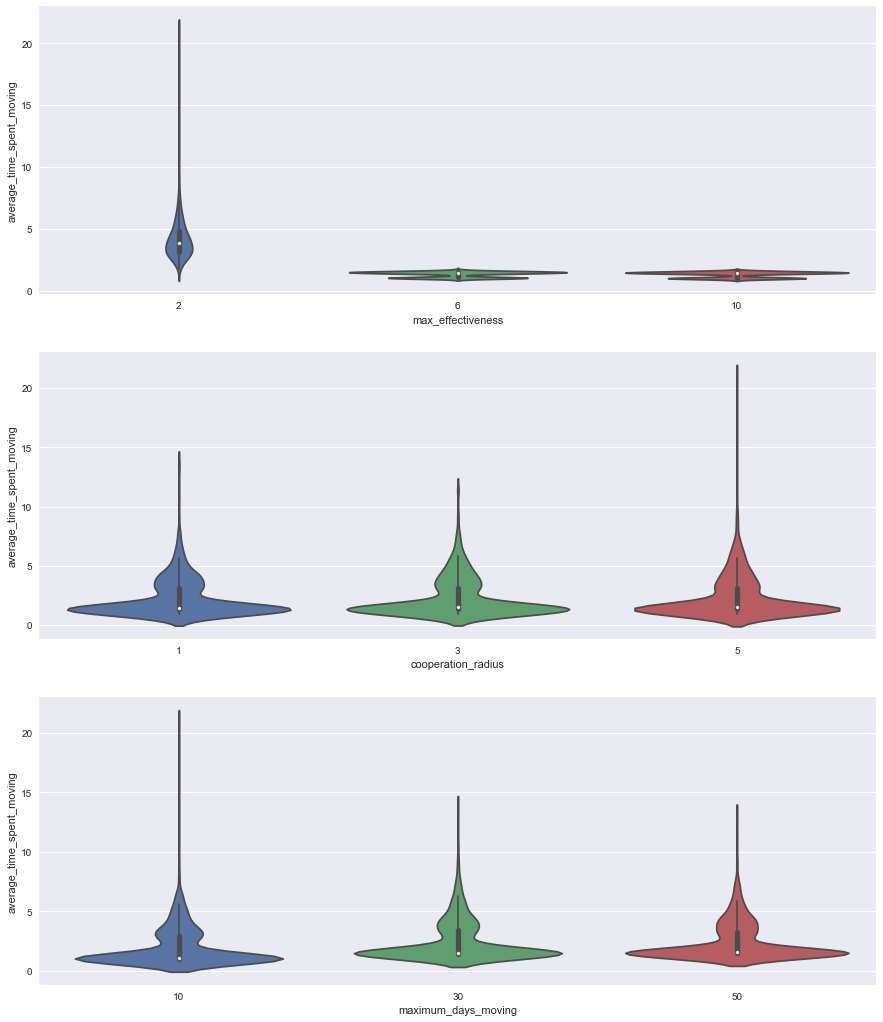

In [36]:
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

sns.violinplot(x="max_effectiveness", y="average_time_spent_moving", data=df_results_small_final, ax=ax1)
sns.violinplot(x="cooperation_radius", y="average_time_spent_moving", data=df_results_small_final, ax=ax2)
sns.violinplot(x="maximum_days_moving", y="average_time_spent_moving", data=df_results_small_final, ax=ax3)

plt.show()

In [ ]:
# Pairplot showing these X and Y variables together
# sns.pairplot(df_results_small_final, x_vars=['max_effectiveness', 'cooperation_radius', 'maximum_days_moving'], 
#              y_vars = ['average_time_spent_moving', 'average_knowledge_locations'])

#### 3.4.3 Selective Runs showcasing average time spent moving

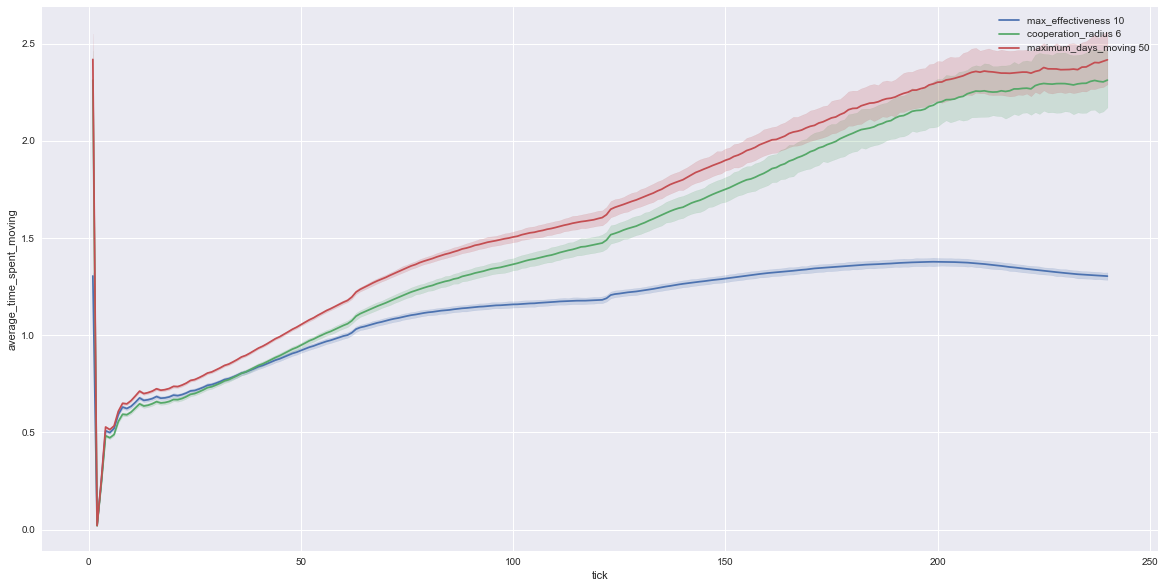

In [7]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="average_time_spent_moving", data=df_results_small[df_results_small['max_effectiveness'] == 10], label="max_effectiveness 10")
ax = sns.lineplot(x="tick", y="average_time_spent_moving", data=df_results_small[df_results_small['cooperation_radius'] == 5], label="cooperation_radius 6")
ax = sns.lineplot(x="tick", y="average_time_spent_moving", data=df_results_small[df_results_small['maximum_days_moving'] == 50], label="maximum_days_moving 50")

plt.show()
# fig.savefig("images/average_time_spent_moving")

### 3.5 Communities by Bands

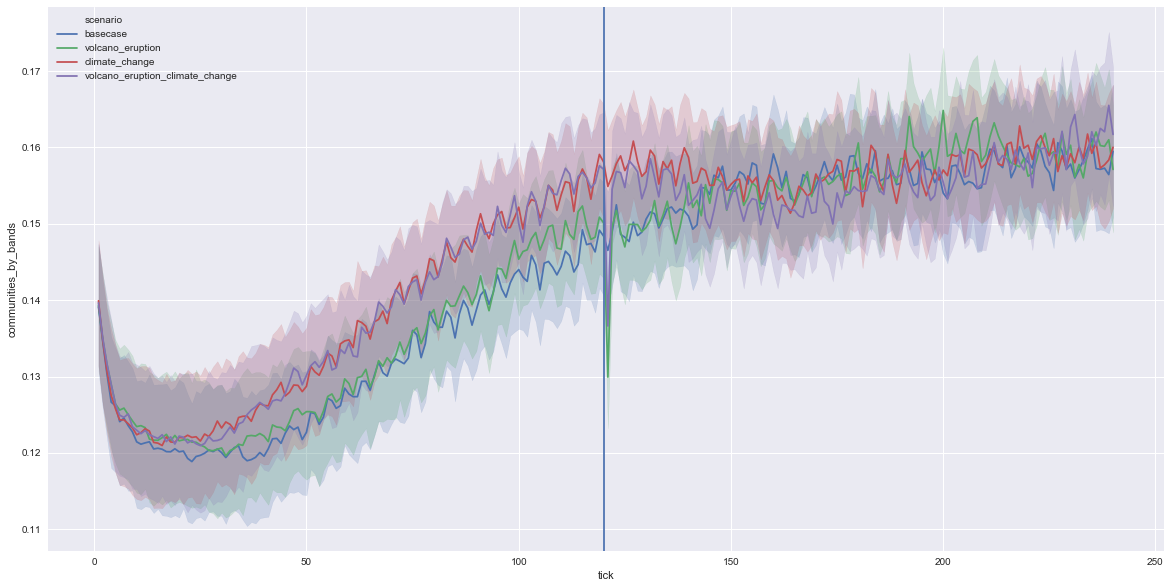

In [8]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x="tick", y="communities_by_bands", data=df_scenarios, hue="scenario", ci = 95)
ax.axvline(x=120)
ax.legend(loc = 'upper left')
plt.show()
fig.savefig('images/communitiesbybands.png')

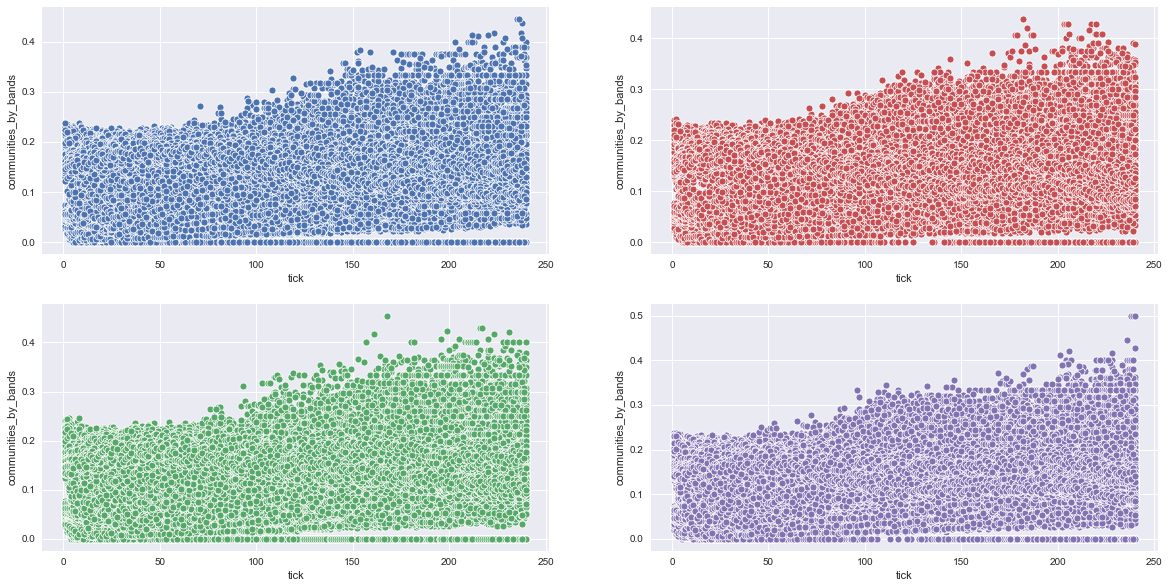

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))
current_palette = sns.color_palette()

sns.scatterplot(x="tick", y="communities_by_bands", data=df_bc, c=current_palette[0], ax = ax1)
sns.scatterplot(x="tick", y="communities_by_bands", data=df_ve, c=current_palette[1], ax = ax2)
sns.scatterplot(x="tick", y="communities_by_bands", data=df_cc, c=current_palette[2], ax = ax3)
sns.scatterplot(x="tick", y="communities_by_bands", data=df_ve_cc, c=current_palette[3], ax = ax4)
plt.show()
fig.savefig('images/communitiesbybands_scenarios')

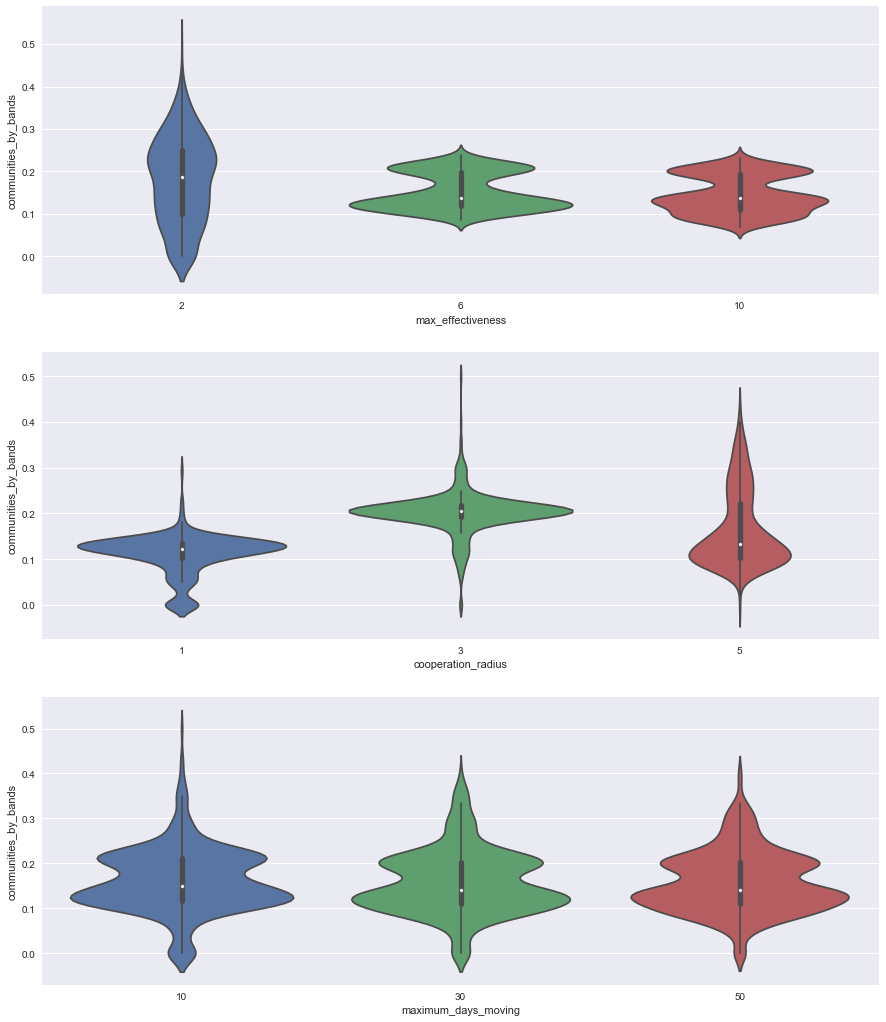

In [12]:
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

sns.violinplot(x="max_effectiveness", y="communities_by_bands", data=df_results_small_final, ax=ax1)
sns.violinplot(x="cooperation_radius", y="communities_by_bands", data=df_results_small_final, ax=ax2)
sns.violinplot(x="maximum_days_moving", y="communities_by_bands", data=df_results_small_final, ax=ax3)

plt.show()
fig.savefig('images/boxplots_communitiesbybands')